In [75]:
# standard libs
import os
import sys
import logging
from functools import partial

# project lib
PROJECT_SRC_PATH = os.path.join(os.path.abspath(''), '..', 'src')
sys.path.append(PROJECT_SRC_PATH)

import utils
import dataset
import visualizations
from prediction_age import AgePredictor
from prediction_floors import FloorsPredictor, FloorsClassifier
from preprocessing import *

# external libs
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
from shapely import wkt

import shap

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from xgboost import XGBRegressor, XGBClassifier, XGBRFClassifier

In [2]:
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data

In [4]:
path_data_france = os.path.join('..', 'data', 'france-cities-200.csv')
data_france = pd.read_csv(path_data_france)
data_france_sample = data_france.sample(frac=.1)

In [100]:
# df_fr = pd.read_pickle('../data/prepared/df-FRA-preliminary.pkl')
df_fr = pd.read_pickle('../data/exp/df-FRA.pkl')

In [ ]:
path_data_netherlands = os.path.join('..', 'data', 'netherlands-cities-200.csv')
data_netherlands = pd.read_csv(path_data_netherlands)
data_netherlands_sample = data_netherlands.sample(frac=.1)

In [28]:
XGBOOST_PARAMS = {'tree_method': 'hist'}
HYPERPARAMETERS = {
    'max_depth': 10,
    'learning_rate': 0.05,
    'n_estimators': 400,
    'colsample_bytree': 0.5,
    'subsample': 1.0,
}

## Preprocessing

In [102]:
df_fr#['floors'].isna().sum()

source_file  dist_to_closest_int  \
0    37221910  BATIMENT-hauts-de-france            30.090792   
     37221913  BATIMENT-hauts-de-france            48.496528   
     37221914  BATIMENT-hauts-de-france            41.540314   
     37221915  BATIMENT-hauts-de-france             7.244667   
     37221916  BATIMENT-hauts-de-france             6.421895   
...                                 ...                  ...   
3566 6673358     BATIMENT-ile-de-france            23.302104   
     6673362     BATIMENT-ile-de-france            88.483345   
     6673372     BATIMENT-ile-de-france            82.484427   
     6673374     BATIMENT-ile-de-france            51.678077   
     6673375     BATIMENT-ile-de-france            74.817814   

               av_footprint_area_within_buffer_100  \
0    37221910                           124.998573   
     37221913                            54.725321   
     37221914                            59.421863   
     37221915                            48.808233   
     37221916                            51.751001   
...                                            ...   
3566 6673358                            115.243499   
     6673362                            624.090822   
     6673372                           1016.606559   
     6673374                             87.565520   
     6673375                             90.775050   

               street_betweeness_global_max_within_buffer_500  \
0    37221910                                        0.164933   
     37221913                                        0.128605   
     37221914                                        0.189860   
     37221915                                        0.189860   
     37221916                                        0.189860   
...                                                       ...   
3566 6673358                                         0.132063   
     6673362                                         0.075730   
     6673372                                         0.107761   
     6673374                                         0.071073   
     6673375                                         0.071073   

               av_elongation_within_buffer_500  \
0    37221910                         0.617657   
     37221913                         0.618377   
     37221914                         0.610407   
     37221915                         0.606612   
     37221916                         0.606765   
...                                        ...   
3566 6673358                          0.665462   
     6673362                          0.647581   
     6673372                          0.644879   
     6673374                          0.644621   
     6673375                          0.629389   

                                      geometry  std_building_footprint_city  \
0    37221910  POINT (3738356.167 3031885.319)                   326.397540   
     37221913  POINT (3738266.506 3031101.807)                   326.397540   
     37221914  POINT (3737626.545 3032330.743)                   326.397540   
     37221915  POINT (3738082.688 3032328.494)                   326.397540   
     37221916  POINT (3738082.348 3032335.014)                   326.397540   
...                                        ...                          ...   
3566 6673358   POINT (3760177.770 2862529.150)                  1114.335337   
     6673362   POINT (3764916.302 2860866.218)                  1114.335337   
     6673372   POINT (3764804.118 2860811.965)                  1114.335337   
     6673374   POINT (3759935.940 2861348.488)                  1114.335337   
     6673375   POINT (3759888.303 2861339.368)                  1114.335337   

                  block  blocks_2_to_4  \
0    37221910  963a6498         1509.0   
     37221913  67164908         1509.0   
     37221914  bf5a6994         1509.0   
     37221915  ec7e3c8e         1509.0   
     37221916  ec7e3c8e         1509.0   
...                 ...    

<AxesSubplot:>

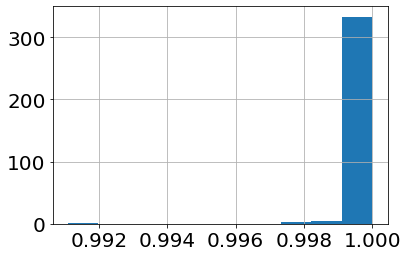

In [99]:
# df_fr[df_fr['floors'].isna()].groupby('city')
df_fr.groupby('city').apply(lambda x: x['floors'].notnull().mean()).hist(bins=10)

In [119]:
# df_audenge = df_fr[df_fr['city'] == 'Audenge']
# df_paris = df_fr[df_fr['id'].str.contains('v0.1-FRA.8.3.')]
# df_dep_58 = df_fr[df_fr['id'].str.contains('v0.1-FRA.7.2.')]
# df_dep_58.to_file('../../building-stock/data/EUBUCCO-FRA-dep-58.gpkg', driver='GPKG')
df_dep_58.to_pickle('../../building-stock/data/EUBUCCO-FRA-dep-58.pkl')
# df_audenge.explore('floors')

: 

In [116]:
df_fr[df_fr['id_source'] == 'BATIMENT0000000289587531']['id']

3109  653422    v0.1-FRA.7.2.5.18_1-5568
Name: id, dtype: object

<AxesSubplot:>

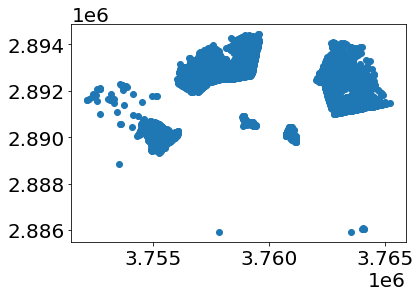

In [111]:
df_paris.plot()

1.0     724637
2.0     559208
3.0      55775
4.0      13608
5.0       5145
6.0       1271
7.0        681
8.0        510
9.0        322
0.0        260
10.0       192
NaN        128
11.0        82
13.0        75
16.0        37
12.0        31
15.0        20
14.0        15
18.0        12
19.0         8
20.0         4
17.0         3
22.0         1
Name: floors, dtype: int64

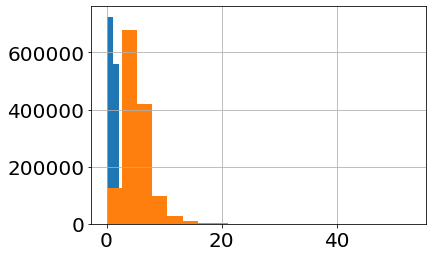

In [36]:
df_fr['floors'].hist(bins=20)
df_fr['height'].hist(bins=20)
df_fr['floors'].value_counts(dropna=False)

## Experiments

,floors
id,
v0.1-FRA.7.2.6.8_1-27059,1.0
v0.1-FRA.1.11.2.11_1-4074,8.0
v0.1-FRA.9.2.3.1_1-4533,1.0
v0.1-FRA.1.10.2.17_1-5698,0.0
v0.1-FRA.11.3.3.8_1-9020,1.0
...,...
v0.1-FRA.6.9.4.8_1-5343,0.0
v0.1-FRA.7.2.6.8_1-27270,1.0
v0.1-FRA.11.4.3.18_1-11986,1.0



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
2024-01-23 13:02:13,674 | INFO : Dataset length: 99998
2024-01-23 13:02:13,689 | INFO : Dataset allocated memory: 104 MB
2024-01-23 13:02:13,804 | INFO : No abort signal received. Continuing... To abort please create /Users/fnachtigall/workspace/ufo-prediction/metadata/local-543cae11.abort.
2024-01-23 13:02:13,806 | INFO : Dataset standard deviation: 0.7142128824769369
2024-01-23 13:02:13,808 | INFO : Dataset average # of floors: 1.5997519950399008
2024-01-23 13:02:13,809 | INFO : Training dataset length: 79998
2024-01-23 13:02:13,810 | INFO : Test dataset length: 20000

A value 

MAE: 0.36 y
RMSE: 0.50 y
R2: 0.5430


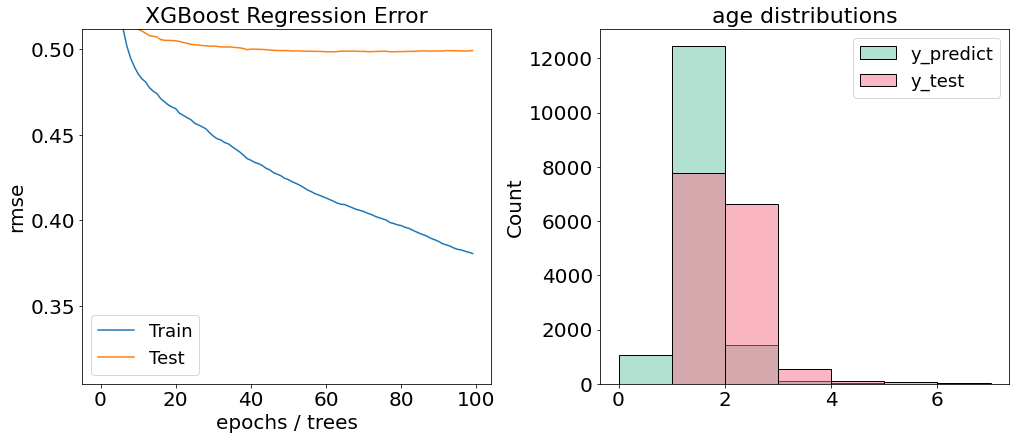

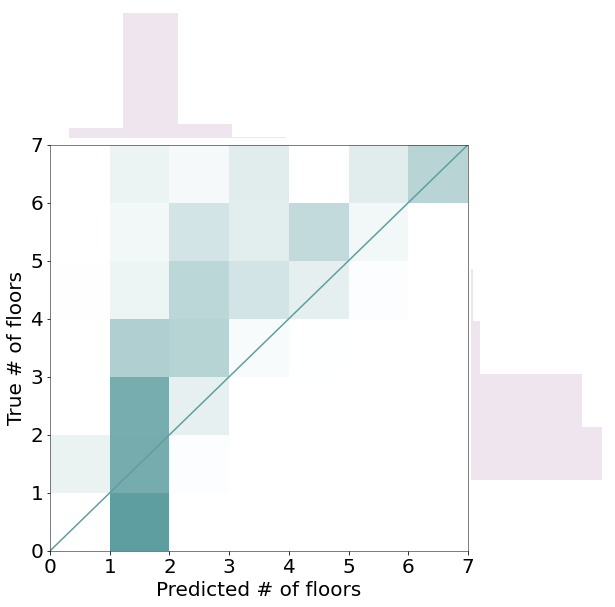

In [95]:
predictor = FloorsPredictor(
    model=XGBRegressor(**XGBOOST_PARAMS),
    # df=df_audenge,
    # df=df_fr.sample(frac=0.1),
    df=df_fr.tail(100000),
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900, use_type_as_feature],
    # preprocessing_stages=[remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES + dataset.BUILDING_FEATURES)],
    # mitigate_class_imbalance=True,
    # hyperparameters=HYPERPARAMETERS,
)
predictor.evaluate_regression()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


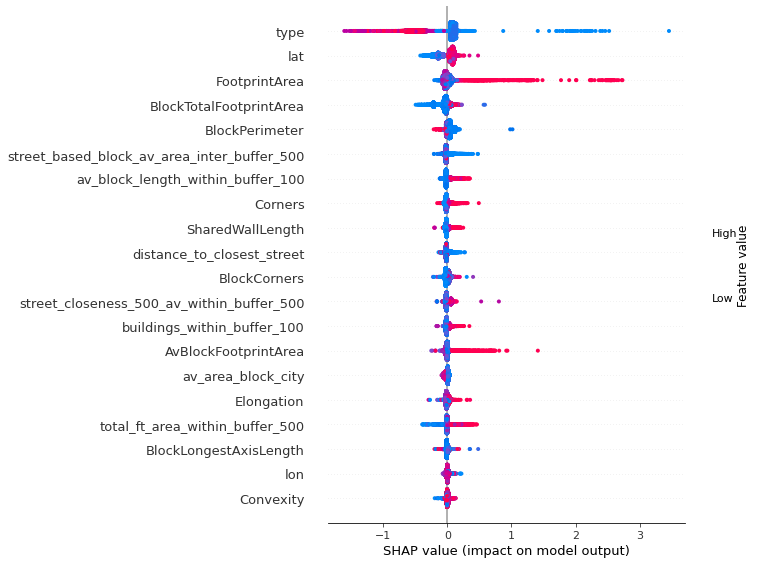

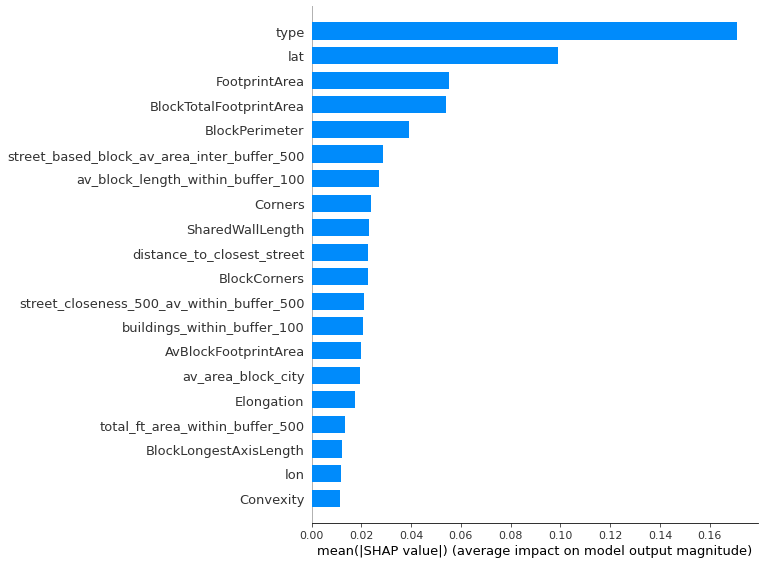

In [82]:
# predictor.normalized_feature_importance()
predictor.SHAP_analysis()

### Classification approach

2024-01-23 12:51:25,786 | INFO : Generated bins: [0, 2, 3, 4, 8, 99]
2024-01-23 12:51:25,787 | INFO : Generated bins with the following labels: ['<2', '2-2', '3-3', '4-7', '8-98']
2024-01-23 12:51:26,084 | INFO : Dataset length: 136187
2024-01-23 12:51:26,091 | INFO : Dataset allocated memory: 142 MB
2024-01-23 12:51:26,257 | INFO : No abort signal received. Continuing... To abort please create /Users/fnachtigall/workspace/ufo-prediction/metadata/local-0c63f142.abort.
2024-01-23 12:51:26,258 | INFO : Training dataset length: 108949
2024-01-23 12:51:26,258 | INFO : Test dataset length: 27238
2024-01-23 12:51:26,263 | INFO : Test cities: ['Fayence' 'Mont-de-Marsan-Sud' 'Vauvert' 'Landivisiau'
 "Saint-Dier-d'Auvergne" 'Gençay' 'Lescar' 'Prémery' 'Saint-Jean-de-Losne'
 'Chambley-Bussières' 'Saint-Ciers-sur-Gironde' 'Retiers' 'Sarzeau'
 'Saint-Rome-de-Tarn' 'Forcalquier' 'Montier-en-Der'
 'Castelsarrasin  2e  Canton' 'Gordes' 'Laroque-Timbaut'
 'Valenciennes-Est' 'Mèze' 'Tonnay-Charente' 'R

Classification report:
               precision    recall  f1-score  support
<2             0.766394  0.805503  0.785462    11738
2-2            0.659228  0.655591  0.657405     8156
3-3            0.422018  0.131241  0.200218      701
4-7            0.591667  0.473333  0.525926      300
8-98           0.789474  0.500000  0.612245       30
accuracy       0.719283  0.719283  0.719283        0
macro avg      0.645756  0.513134  0.556251    20925
weighted avg   0.710615  0.719283  0.711973    20925
Cohen’s kappa: 0.4577
Matthews correlation coefficient (MCC): 0.4585


FixedFormatter should only be used together with FixedLocator


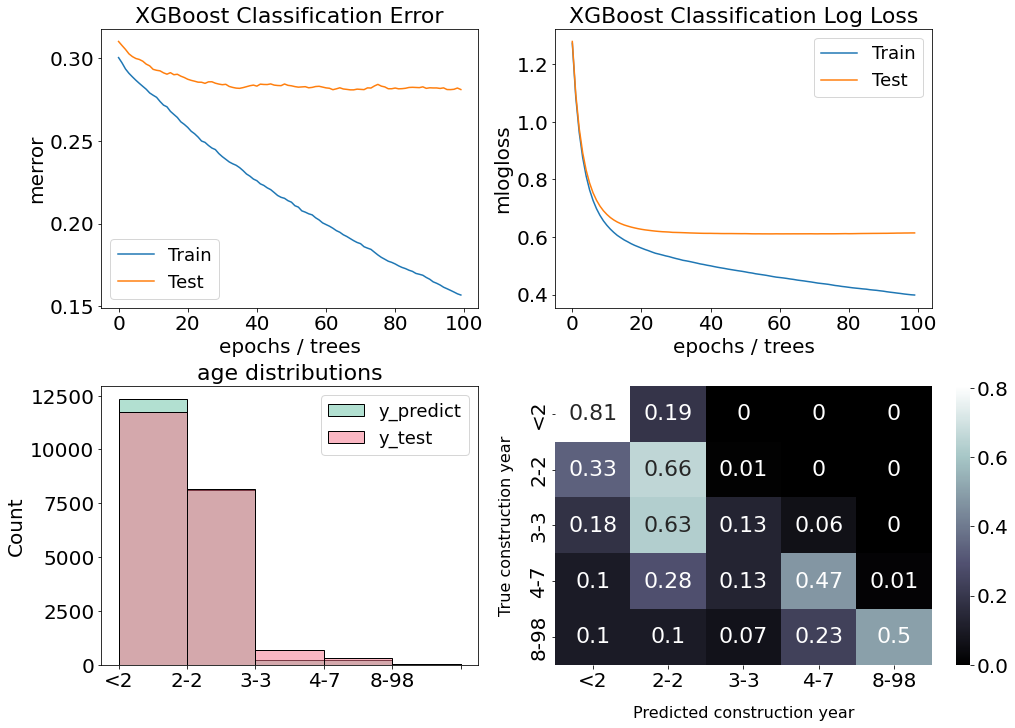

In [83]:
classifier = FloorsClassifier(
    model=XGBClassifier(**XGBOOST_PARAMS),
    # df=df_audenge,
    df=df_fr.sample(frac=0.1),
    # df=df_fr.tail(100000),
    bins=[0, 2, 3, 4, 8, 99],
    test_training_split=split_80_20,
    preprocessing_stages=[remove_buildings_pre_1900, use_type_as_feature],
    # preprocessing_stages=[remove_buildings_pre_1900, partial(filter_features, selection=dataset.STREET_FEATURES + dataset.BUILDING_FEATURES)],
    # mitigate_class_imbalance=True,
    # hyperparameters=HYPERPARAMETERS,
)
classifier.evaluate()

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


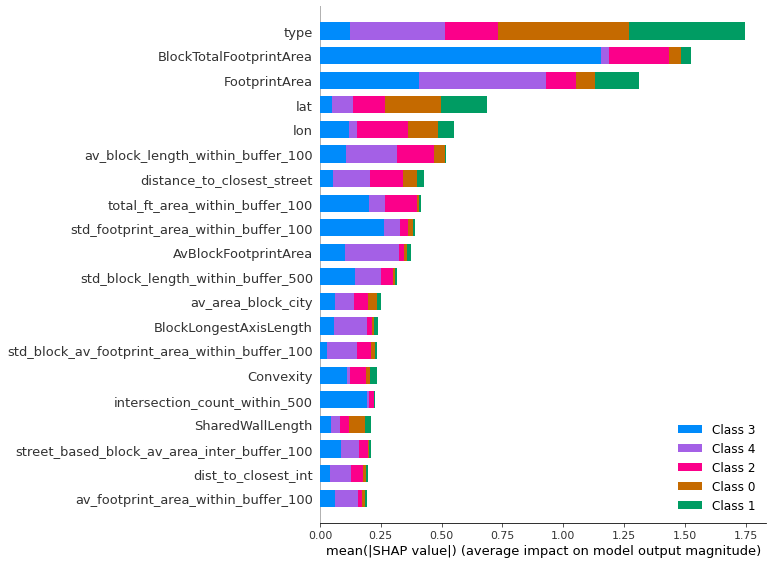

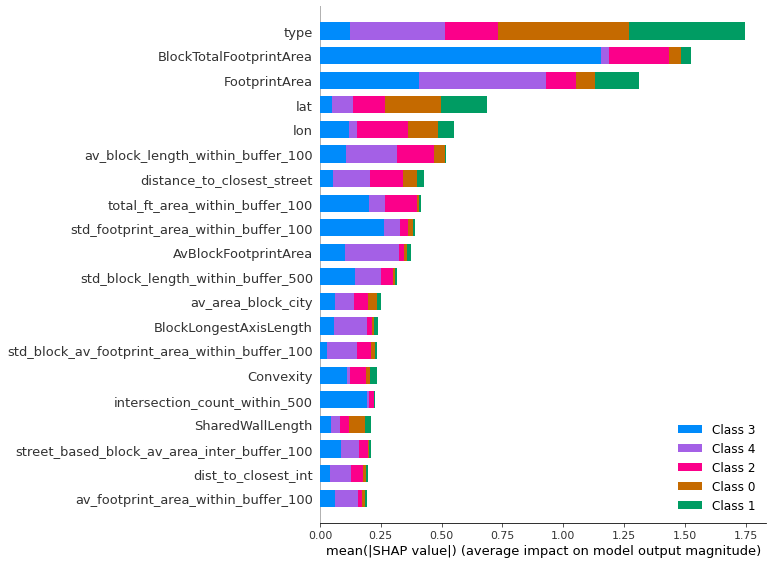

In [84]:
classifier.SHAP_analysis()